# Cell Division 

## On a 2D mesh

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue import Sheet, config


from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model

from tyssue.draw.plt_draw import sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

solver = QSSolver()

Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the vert dataset with new specs


Number of cells: 20
          edges: 116
          vertices: 54



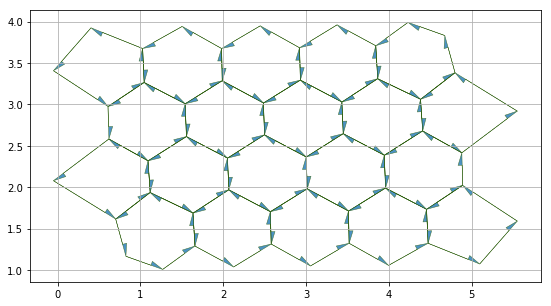

In [2]:
sheet = Sheet.planar_sheet_2d('division', 6, 6, 1, 1)
sheet.sanitize()
geom.update_all(sheet)

sheet.get_opposite()

# ## Set up the model
nondim_specs = config.dynamics.quasistatic_plane_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

print("Number of cells: {}\n"
      "          edges: {}\n"
      "          vertices: {}\n".format(sheet.Nf, sheet.Ne, sheet.Nv))

# ## Minimize energy
res = solver.find_energy_min(sheet, geom, model)

# ## View the result
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.1
fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

True


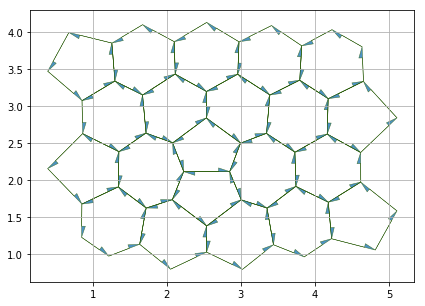

In [3]:
daughter = cell_division(sheet, 7, geom, angle=np.pi/2)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

## Division in a 3D single layer epithelium

In [4]:
from tyssue.io.hdf5 import save_datasets, load_datasets
# redefine cell_division from monolayer related topology module
from tyssue.topology.monolayer_topology import cell_division

from tyssue.core.monolayer import Monolayer
from tyssue.geometry.bulk_geometry import BulkGeometry
from tyssue.dynamics.bulk_model import BulkModel#, set_model
#from tyssue.draw.vispy_draw import vp_view


In [5]:
datasets = load_datasets('../examples/small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])

specs = config.geometry.bulk_spec()
monolayer = Monolayer('ell', datasets, specs)


In [6]:
mother = 8
daughter = cell_division(monolayer, mother, 
                         orientation='vertical')

monolayer.validate()

True

In [7]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'
ipv.clear()
fig, mesh = view_ipv(monolayer, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.3rc1-py3.7-linux-x86_64.egg/tyssue/draw/ipv_draw.py:73: UserWarning: `view_ipv` is deprecated, use the more generic `sheet_view`
  warnings.warn("`view_ipv` is deprecated, use the more generic `sheet_view`")


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [8]:
mother = 18
daughter = cell_division(monolayer, mother, 
                         orientation='horizontal')
monolayer.validate()

True

In [9]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'


ipv.clear()
fig, mesh = view_ipv(monolayer, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [10]:
from tyssue.utils import single_cell

single = single_cell(monolayer, mother)


rho = np.linalg.norm(single.vert_df[single.coords], axis=1)
rho = pd.Series(rho, index=single.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors

draw_specs['face']['color'] = '#aaaaaaaa'
ipv.clear()
fig, mesh = view_ipv(single, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

#### Energy minimisation of the monolayer after division

> Note that this needs some more work

In [11]:
monolayer.update_specs(config.dynamics.quasistatic_bulk_spec())
monolayer.cell_df.loc[[mother, daughter], 'prefered_area'] /= 2
monolayer.cell_df.loc[[mother, daughter], 'prefered_vol'] /= 3

res = solver.find_energy_min(monolayer, BulkGeometry, BulkModel)
print(res['message'])
rho = np.linalg.norm(monolayer.vert_df[single.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors

draw_specs['face']['color'] = '#aaaaaaaa'
ipv.clear()
fig, mesh = view_ipv(monolayer, coords=['x', 'y', 'z'],
                     **draw_specs['edge'])
fig

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [12]:
from tyssue.generation import three_faces_sheet, extrude
from tyssue.geometry.bulk_geometry import MonoLayerGeometry


datasets_2d, _ = three_faces_sheet(zaxis=True)
datasets = extrude(datasets_2d, method='translation')
eptm = Monolayer('test_volume', datasets, 
                 config.geometry.bulk_spec(),
                 coords=['x','y','z'])
#eptm.vert_df[eptm.coords] += np.random.normal(scale=1e-3,
#                                              size=eptm.vert_df[eptm.coords].shape)
MonoLayerGeometry.update_all(eptm)

for orientation in ['vertical', 'horizontal']:
    print(orientation)
    daughter = cell_division(eptm, 1,
                             orientation=orientation)
    eptm.reset_topo()
    eptm.reset_index()
    MonoLayerGeometry.update_all(eptm)
    print(f'Valid division for {orientation}:')
    print(eptm.validate()) #break

vertical
Valid division for vertical:
True
horizontal
Valid division for horizontal:
True
